# CNN에 실제 데이터셋 적용하기: MNIST dataset

In [1]:
import torch #파이토치
import torchvision.datasets as dsets #MNIST 데이터셋을 불러옴
import torchvision.transforms as transforms #이미지 변환 툴
import torch.nn.init #텐서에 초기값을 줌

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

## 하이퍼 파라미터

In [3]:
learning_rate = 0.001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 15 #반복학습의 횟수
batch_size = 100 #한 iteration에서 사용할 데이터 크기

## MNIST dataset

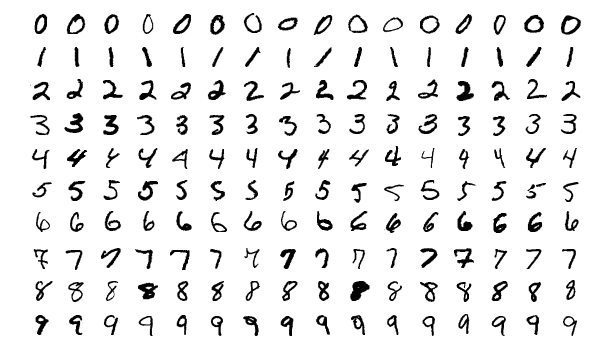

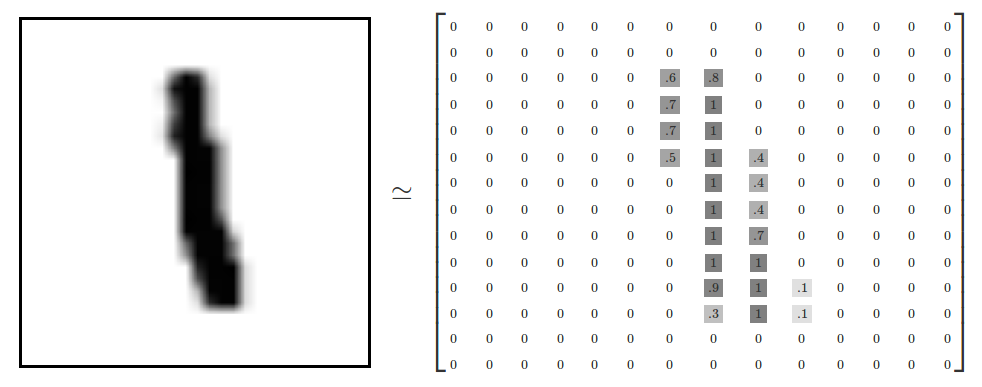

MNIST 데이터셋은 숫자 손글씨 이미지로 구성된 간단한 Computer Vision 데이터입니다. 한 이미지는 28*28 크기의 픽셀로 이루어져 있으며 각 픽셀은 0과 1 사이의 값을 가집니다. training set은 6만개, test set은 만개의 이미지를 갖고 있습니다. torch의 datasets를 이용하면 로컬에 다운받지 않아도 이용할 수 있습니다.

In [4]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [5]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

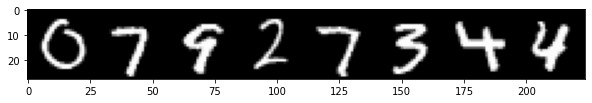

In [6]:
# 데이터(이미지) 확인해보기
from torchvision import utils

dataiter       = iter(data_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images[:8], padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

## CNN 모델 설계

### pytorch로 직접 CNN 모델 설계하기

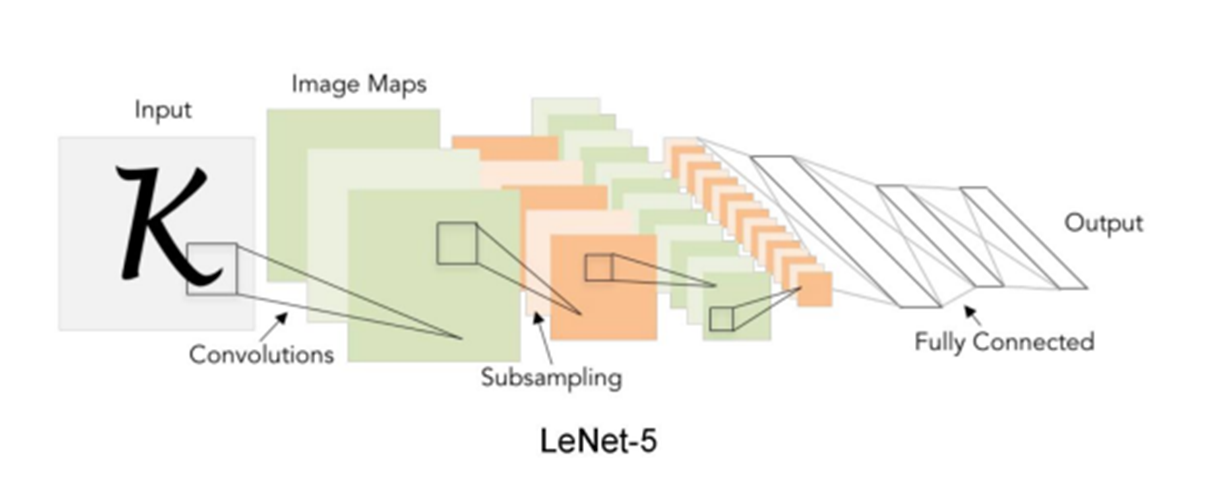

In [7]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # first layer
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.MaxPool2d(kernel_size=2, stride=2))   # pooling

        # second layer
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # fully-connected layer 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # fully-connected layer 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc(out) # fully-connected layer 통과
        return out

shape에서 -1의 의미: 이미 고정된 열 또는 행 차원에서 추정되는 나머지 차원. 만약 데이터가 총 12개이고, 이를 (2, -1)로 reshape한다면 (2, 6)차원의 행렬이 될 것이다.

## training

In [8]:
model1 = CNN().to(device)   #모델 정의 및 gpu에 할당

In [9]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)   #optimizer 정의, Adam으로 설정

In [10]:
def training_model(model, data, epochs):
  total_batch = len(data)

  for epoch in range(epochs):
    avg_cost = 0

    for X, Y in data:  #data_loader에 배치들이 저장되어 있음. 한 iteration당 한 개의 배치를 꺼내와서 사용
        X = X.to(device)   #이미지
        Y = Y.to(device)   #레이블(해당 이미지가 뜻하는 숫자)

        optimizer.zero_grad()   #지난 iteration에서 계산했던 기울기 초기화
        hypothesis = model(X)   #순전파 과정으로 예측값 도출
        cost = criterion(hypothesis, Y)   #예측값과 실제값을 비교한 loss
        cost.backward()   #역전파, 기울기 계산
        optimizer.step()   #optimizer로 가중치 갱신

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [11]:
#모델 학습
training_model(model = model1, data = data_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.228673264
[Epoch:    2] cost = 0.0667562485
[Epoch:    3] cost = 0.0490289256
[Epoch:    4] cost = 0.0399321541
[Epoch:    5] cost = 0.033129856
[Epoch:    6] cost = 0.0275503919
[Epoch:    7] cost = 0.0236624368
[Epoch:    8] cost = 0.020249052
[Epoch:    9] cost = 0.0172905196
[Epoch:   10] cost = 0.0147370035
[Epoch:   11] cost = 0.0130898505
[Epoch:   12] cost = 0.0105513688
[Epoch:   13] cost = 0.00899304915
[Epoch:   14] cost = 0.00939819124
[Epoch:   15] cost = 0.00808064546


## test

In [12]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model1(X_test)   # 학습한 모델로 test 데이터의 예측값 도출(각 숫자에 해당할 확률)
    correct_prediction = torch.argmax(prediction, 1) == Y_test   # 모든 확률 중에서 가장 큰 확률을 가진 숫자를 예측값으로 지정하고 이를 실제값과 비교
    accuracy = correct_prediction.float().mean()   # 정확도 계산
    print('Accuracy:', accuracy.item())

Accuracy: 0.979699969291687


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


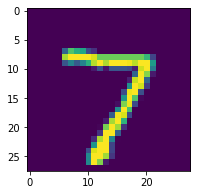

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
tensor(True, device='cuda:0')


In [13]:
sample_data = mnist_test.test_data[0]
sample_img = sample_data.numpy()
plt.figure(figsize=(3, 3))
plt.imshow(sample_img)
plt.show()

print(torch.argmax(prediction, 1))
print(correct_prediction[0])

# 더 좋은 CNN 모델을 만드는 방법

CNN 모델에 layer를 추가하는 방법을 알아봅시다.

In [14]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5

        # first layer (1->32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out

In [15]:
model2 = CNN().to(device)

In [16]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [17]:
#모델 학습
training_model(model = model2, data = data_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.187655538
[Epoch:    2] cost = 0.0540852062
[Epoch:    3] cost = 0.0356024504
[Epoch:    4] cost = 0.0282595158
[Epoch:    5] cost = 0.0225950424
[Epoch:    6] cost = 0.0182485506
[Epoch:    7] cost = 0.0176903289
[Epoch:    8] cost = 0.0139475428
[Epoch:    9] cost = 0.0128437784
[Epoch:   10] cost = 0.0112562124
[Epoch:   11] cost = 0.00994583592
[Epoch:   12] cost = 0.00874825101
[Epoch:   13] cost = 0.0083432328
[Epoch:   14] cost = 0.00658853445
[Epoch:   15] cost = 0.00827904977


In [18]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model2(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9268999695777893


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# 4주차 과제

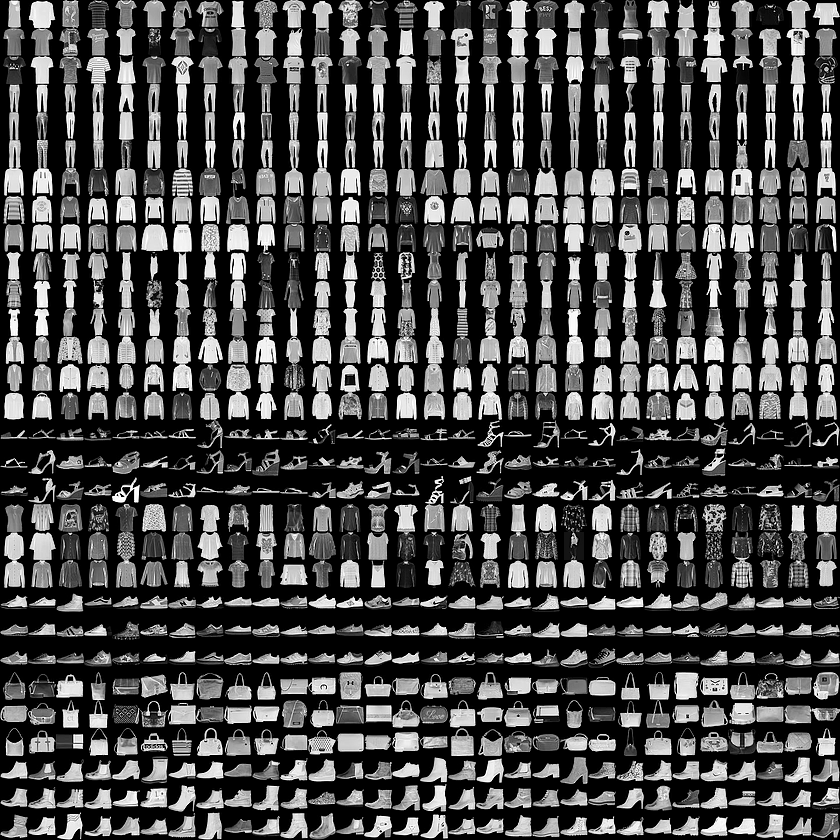

fashon MNIST 데이터셋은 운동화, 셔츠 등 다양한 의류 이미지와 그 종류 라벨로 구성된 computer vision 데이터이다. 한 이미지는 28*28이며 10가지의 종류로 분류된다.

- 4주차 과제: fashion MNIST 데이터셋을 사용하여 의류 이미지를 분류하는 CNN 만들기

---

- 형식/ 제출 방식

  다다음주 화-수요일(2월 8-9일)까지 github의 4주차 폴더에 제출해주세요.



> (필수) 여러가지를 시도해보시면서(레이어 개수, 노드 개수, 활성화 함수, optimizer, 배치 정규화 등등) 가장 정확도가 높은 것만 남기지 마시고 시도했던 모든 버전의 코드와 그 모델의 정확도를 남겨주세요. 적어도 3가지 정도의 버전이 있으면 바람직할 것 같습니다. 이 버전은 무엇을 바꾸고, 무엇을 시도한 버전인지도 작성해주세요.



---

- 발표

 제출된 것들 중   
  (1) 성능이 높거나,    
  (2) 흥미로운 시도를 해본 것  
기준으로 3 건을 뽑아서 발표하도록 하겠습니다!  모두가 업로드 한 시점으로부터 최대한 빠르게 발표할 사람을 알려드리도록 하겠습니다!  



하다가 질문 생기면 편하게 말씀해주세요~  





In [ ]:
trainset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

In [20]:
learning_rate = 0.1
training_epochs = 15 
batch_size = 100

In [21]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

In [ ]:
# 직접 CNN 클래스를 만들어봅시다.

'''
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5

        # first layer (1->32)
        ...
'''

In [23]:
model = CNN().to(device)

In [ ]:
# loss function과 optimizer를 정해봅시다.

'''
criterion = 
optimizer = 
'''

In [ ]:
# 모델을 학습시켜봅시다.

training_model(model = model, data = train_loader, epochs = training_epochs)

In [ ]:
# test 데이터를 사용하여 모델의 성능(정확도)을 확인해봅시다.

correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)